![battle_of_bastards](../img/Battle_of_Bastards_ShieldWall_v005.jpg)

# Game of Thrones - Battle Prediction
Game of Thrones is a popular fantasy TV show based on a series of books written by George RR Martin.

This notebook showcases the analysis and predictions of the battles in the series.

Load packages

In [90]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
from pylab import rcParams
from collections import Counter
from time import time
from pandas_profiling import ProfileReport
from IPython.display import display
import statsmodels.api as sm
import plotly.express as px
# Import supplementary visualization code visuals.py
import visuals as vs
rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# @hidden_cell
import warnings
warnings.filterwarnings("ignore")

Load dataset

In [3]:
battles_df = pd.read_csv('../data/battles.csv')
battles_df.head()

name  year  battle_number             attacker_king  \
0        Battle of Winterfell   299             12       Balon/Euron Greyjoy   
1           Sack of Harrenhal   299             18                Robb Stark   
2  Battle of Torrhen's Square   299             11                Robb Stark   
3   Battle of the Stony Shore   299             10       Balon/Euron Greyjoy   
4          Sack of Winterfell   299             14  Joffrey/Tommen Baratheon   

              defender_king attacker_1 attacker_2 attacker_3 attacker_4  \
0                Robb Stark    Greyjoy        NaN        NaN        NaN   
1  Joffrey/Tommen Baratheon      Stark        NaN        NaN        NaN   
2       Balon/Euron Greyjoy      Stark        NaN        NaN        NaN   
3                Robb Stark    Greyjoy        NaN        NaN        NaN   
4                Robb Stark     Bolton    Greyjoy        NaN        NaN   

  defender_1  ... major_death  major_capture  attacker_size defender_size  \
0      Stark  ...         0.0            1.0           20.0           NaN   
1  Lannister  ...         1.0            0.0          100.0         100.0   
2    Greyjoy  ...         0.0            0.0          244.0         900.0   
3      Stark  ...         0.0            0.0          264.0           NaN   
4      Stark  ...         1.0            0.0          618.0        2000.0   

                        attacker_commander  \
0                            Theon Greyjoy   
1  Roose Bolton, Vargo Hoat, Robett Glover   
2               Rodrik Cassel, Cley Cerwyn   
3                            Theon Greyjoy   
4              Ramsay Snow, Theon Greyjoy    

                             defender_commander  summer          location  \
0                                    Bran Stark     1.0        Winterfell   
1                                   Amory Lorch     1.0         Harrenhal   
2                               Dagmer Cleftjaw     1.0  Torrhen's Square   
3                                           NaN     1.0       Stony Shore   
4  Rodrik Cassel, Cley Cerwyn, Leobald Tallhart     1.0        Winterfell   

           region                                               note  
0       The North  It isn't mentioned how many Stark men are left...  
1  The Riverlands                                                NaN  
2       The North  Greyjoy's troop number comes from the 264 esti...  
3       The North  Greyjoy's troop number based on the Battle of ...  
4       The North  Since House Bolton betrays the Starks for Hous...  

[5 rows x 25 columns]

In reviewing the other kernels to see what has been done, [one particular kernel](https://www.kaggle.com/chrisbuetti/predicting-battle-outcomes-start-rmd) on Kaggle pointed out the data entry mistake on the Battle of Castle Rock. Having watched the TV series, I know for a fact that Mance Rayder has 100K wildings and Stannis Baratheon has 1,240 troops. I flipped the names in the dataset. This should be a major callout to anyone using this dataset

# Data Cleaning

Change `attacker_outcome` to boolean and fill nan with zeros for `major_death`,	`major_capture`, `summer`.

In [4]:
battles_df['attacker_outcome_flag'] = battles_df['attacker_outcome'].map({'win': 1, 'loss': 0})

battles_df['attacker_outcome_flag'] = battles_df['attacker_outcome_flag'].fillna(0)
battles_df['major_death'] = battles_df['major_death'].fillna(0)
battles_df['major_capture'] = battles_df['major_capture'].fillna(0)
battles_df['summer'] = battles_df['summer'].fillna(0)
battles_df[['attacker_outcome','major_death','major_capture','summer']].head()

attacker_outcome  major_death  major_capture  summer
0              win          0.0            1.0     1.0
1              win          1.0            0.0     1.0
2              win          0.0            0.0     1.0
3              win          0.0            0.0     1.0
4              win          1.0            0.0     1.0

### Run pandas profiler for fast EDA

In [5]:
profile = ProfileReport(battles_df, title='Game of Thrones Battles - Pandas Profiling Report', style={'full_width':True})
profile

In [6]:
profile.to_file(output_file="../output/got_battles_data_profile.html")

The columns `attacker_2`,`attacker_3`,`attacker_4`,`defender_2`,`defender_3`,`defender_4`, `attacker_commander`, `defender_commander` can be used to count the number of houses involved in the battle. 

Three columns will be created for:   

* Number of attacking houses
* Number of defending houses 
* Number of attacker_commander	
* Number of defender_commander
* Battle Size


In [7]:
battles_df['attack_houses'] = battles_df[['attacker_1','attacker_2','attacker_3','attacker_4']].notnull().sum(axis=1)
battles_df['attack_houses'] = pd.to_numeric(battles_df.attack_houses)

battles_df['defender_houses'] = battles_df[['defender_1','defender_2','defender_3','defender_4']].notnull().sum(axis=1)
battles_df['defender_houses'] = pd.to_numeric(battles_df.defender_houses)

# Check data
battles_df[['attacker_1','attacker_2','attacker_3','attacker_4','attack_houses','defender_1','defender_2','defender_3','defender_4','defender_houses']].sort_values(by=['attack_houses','defender_houses'],ascending=[False,False]).head()

attacker_1 attacker_2 attacker_3 attacker_4  attack_houses     defender_1  \
14  Baratheon   Karstark    Mormont     Glover              4         Bolton   
12  Baratheon   Karstark    Mormont     Glover              4        Greyjoy   
23  Free folk     Thenns     Giants        NaN              3  Night's Watch   
4      Bolton    Greyjoy        NaN        NaN              2          Stark   
6     Bracken  Lannister        NaN        NaN              2      Blackwood   

   defender_2  defender_3  defender_4  defender_houses  
14       Frey         NaN         NaN                2  
12        NaN         NaN         NaN                1  
23  Baratheon         NaN         NaN                2  
4         NaN         NaN         NaN                1  
6         NaN         NaN         NaN                1

Count occurence of `attacker_commander` and `defender_commander`

In [8]:
battles_df['attacker_commander'].str.split(',', expand=True).head()

0                1               2     3     4     5
0  Theon Greyjoy             None            None  None  None  None
1   Roose Bolton       Vargo Hoat   Robett Glover  None  None  None
2  Rodrik Cassel      Cley Cerwyn            None  None  None  None
3  Theon Greyjoy             None            None  None  None  None
4    Ramsay Snow   Theon Greyjoy             None  None  None  None

In [9]:
battles_df['attacker_commander_count'] = battles_df['attacker_commander'].str.split(',', expand=True).notnull().sum(axis=1)
battles_df[['attacker_commander','attacker_commander_count']].head()

attacker_commander  attacker_commander_count
0                            Theon Greyjoy                         1
1  Roose Bolton, Vargo Hoat, Robett Glover                         3
2               Rodrik Cassel, Cley Cerwyn                         2
3                            Theon Greyjoy                         1
4              Ramsay Snow, Theon Greyjoy                          2

In [10]:
battles_df['defender_commander'].str.split(',', expand=True).head()

0             1                  2     3     4     5     6
0       Bran Stark          None               None  None  None  None  None
1      Amory Lorch          None               None  None  None  None  None
2  Dagmer Cleftjaw          None               None  None  None  None  None
3              NaN           NaN                NaN   NaN   NaN   NaN   NaN
4    Rodrik Cassel   Cley Cerwyn   Leobald Tallhart  None  None  None  None

In [11]:
battles_df['defender_commander_count'] = battles_df['defender_commander'].str.split(',', expand=True).notnull().sum(axis=1)
battles_df[['defender_commander','defender_commander_count']].head()

defender_commander  defender_commander_count
0                                    Bran Stark                         1
1                                   Amory Lorch                         1
2                               Dagmer Cleftjaw                         1
3                                           NaN                         0
4  Rodrik Cassel, Cley Cerwyn, Leobald Tallhart                         3

Drop columns with missing data

In [12]:
battles_df = battles_df.drop(columns = ['battle_number','attacker_2','attacker_3','attacker_4','defender_2','defender_3','defender_4','note'])
battles_df.head()

name  year             attacker_king  \
0        Battle of Winterfell   299       Balon/Euron Greyjoy   
1           Sack of Harrenhal   299                Robb Stark   
2  Battle of Torrhen's Square   299                Robb Stark   
3   Battle of the Stony Shore   299       Balon/Euron Greyjoy   
4          Sack of Winterfell   299  Joffrey/Tommen Baratheon   

              defender_king attacker_1 defender_1 attacker_outcome  \
0                Robb Stark    Greyjoy      Stark              win   
1  Joffrey/Tommen Baratheon      Stark  Lannister              win   
2       Balon/Euron Greyjoy      Stark    Greyjoy              win   
3                Robb Stark    Greyjoy      Stark              win   
4                Robb Stark     Bolton      Stark              win   

      battle_type  major_death  major_capture  ...  \
0          ambush          0.0            1.0  ...   
1          ambush          1.0            0.0  ...   
2  pitched battle          0.0            0.0  ...   
3          ambush          0.0            0.0  ...   
4          ambush          1.0            0.0  ...   

                        attacker_commander  \
0                            Theon Greyjoy   
1  Roose Bolton, Vargo Hoat, Robett Glover   
2               Rodrik Cassel, Cley Cerwyn   
3                            Theon Greyjoy   
4              Ramsay Snow, Theon Greyjoy    

                             defender_commander summer          location  \
0                                    Bran Stark    1.0        Winterfell   
1                                   Amory Lorch    1.0         Harrenhal   
2                               Dagmer Cleftjaw    1.0  Torrhen's Square   
3                                           NaN    1.0       Stony Shore   
4  Rodrik Cassel, Cley Cerwyn, Leobald Tallhart    1.0        Winterfell   

           region attacker_outcome_flag attack_houses  defender_houses  \
0       The North                   1.0             1                1   
1  The Riverlands                   1.0             1                1   
2       The North                   1.0             1                1   
3       The North                   1.0             1                1   
4       The North                   1.0             2                1   

   attacker_commander_count  defender_commander_count  
0                         1                         1  
1                         3                         1  
2                         2                         1  
3                         1                         0  
4                         2                         3  

[5 rows x 22 columns]

Create `battle_size` for the total number of people involved in a battle.

In [13]:
battles_df['battle_size'] = battles_df['attacker_size'] + battles_df['defender_size']
battles_df[['attacker_size','defender_size','battle_size']].head()

attacker_size  defender_size  battle_size
0           20.0            NaN          NaN
1          100.0          100.0        200.0
2          244.0          900.0       1144.0
3          264.0            NaN          NaN
4          618.0         2000.0       2618.0

Plot correlation

In [14]:
corr_plot = battles_df.corr(method='pearson').style.set_caption('Correlation for Game of Thrones Battles').background_gradient(cmap='coolwarm').set_precision(4)
corr_plot

Run profiler again

In [15]:
profile = ProfileReport(battles_df, title='Game of Thrones Battles - Pandas Profiling Report', style={'full_width':True})
profile
profile.to_file(output_file="../output/got_battles_data_profile.html")

# Write function to clean battles dataset

In [86]:
def clean_battle_data(df):
    df['attacker_outcome_flag'] = df['attacker_outcome'].map({'win': 1, 'loss': 0})

    # Fill NaN with zero
    df['attacker_outcome_flag'] = df['attacker_outcome_flag'].fillna(0)
    df['major_death'] = df['major_death'].fillna(0)
    df['major_capture'] = df['major_capture'].fillna(0)
    df['summer'] = df['summer'].fillna(0)
    df['attacker_size'] = df['attacker_size'].fillna(0)
    df['defender_size'] = df['defender_size'].fillna(0)

    # The columns attacker_2,attacker_3,attacker_4,defender_2,defender_3,defender_4, attacker_commander, defender_commander can be used to count the number of houses involved in the battle.
    df['attack_houses'] = df[['attacker_1','attacker_2','attacker_3','attacker_4']].notnull().sum(axis=1)
    df['attack_houses'] = pd.to_numeric(df.attack_houses)

    df['defender_houses'] = df[['defender_1','defender_2','defender_3','defender_4']].notnull().sum(axis=1)
    df['defender_houses'] = pd.to_numeric(df.defender_houses)

    # Count attacker_commander
    df['attacker_commander_count'] = df['attacker_commander'].str.split(',', expand=True).notnull().sum(axis=1)

    # Count defender_commander
    df['defender_commander_count'] = df['defender_commander'].str.split(',', expand=True).notnull().sum(axis=1)

    # Drop columns with missing data
    df = df.drop(columns = ['battle_number','attacker_2','attacker_3','attacker_4','defender_2','defender_3','defender_4','note'])

    # Create battle_size columns
    df['battle_size'] = df['attacker_size'] + df['defender_size']
    df['battle_size'] = df['battle_size'].fillna(0)

    return df

Test function

In [87]:
battles_df = pd.read_csv('../data/battles.csv')
battles_df = clean_battle_data(battles_df)
battles_df.head()

name  year             attacker_king  \
0        Battle of Winterfell   299       Balon/Euron Greyjoy   
1           Sack of Harrenhal   299                Robb Stark   
2  Battle of Torrhen's Square   299                Robb Stark   
3   Battle of the Stony Shore   299       Balon/Euron Greyjoy   
4          Sack of Winterfell   299  Joffrey/Tommen Baratheon   

              defender_king attacker_1 defender_1 attacker_outcome  \
0                Robb Stark    Greyjoy      Stark              win   
1  Joffrey/Tommen Baratheon      Stark  Lannister              win   
2       Balon/Euron Greyjoy      Stark    Greyjoy              win   
3                Robb Stark    Greyjoy      Stark              win   
4                Robb Stark     Bolton      Stark              win   

      battle_type  major_death  major_capture  ...  \
0          ambush          0.0            1.0  ...   
1          ambush          1.0            0.0  ...   
2  pitched battle          0.0            0.0  ...   
3          ambush          0.0            0.0  ...   
4          ambush          1.0            0.0  ...   

                             defender_commander  summer          location  \
0                                    Bran Stark     1.0        Winterfell   
1                                   Amory Lorch     1.0         Harrenhal   
2                               Dagmer Cleftjaw     1.0  Torrhen's Square   
3                                           NaN     1.0       Stony Shore   
4  Rodrik Cassel, Cley Cerwyn, Leobald Tallhart     1.0        Winterfell   

           region  attacker_outcome_flag attack_houses defender_houses  \
0       The North                    1.0             1               1   
1  The Riverlands                    1.0             1               1   
2       The North                    1.0             1               1   
3       The North                    1.0             1               1   
4       The North                    1.0             2               1   

   attacker_commander_count  defender_commander_count  battle_size  
0                         1                         1         20.0  
1                         3                         1        200.0  
2                         2                         1       1144.0  
3                         1                         0        264.0  
4                         2                         3       2618.0  

[5 rows x 23 columns]

Export clean data

In [18]:
battles_df.to_csv('../data/battles_clean.csv', index = False)

# Exploratory Data Analysis

In [19]:
profile

### Using the Fast EDA (one dimension):

**`attacker_outcome`**  
32 battles out of 38 battles were won (84.2%).

**`attacker_king`**  
On the offense, Joffrey/Tommen Baratheon were the attacking kings 36.8% of the time (14 battles) while Mance Rayder was only the attacking king once (5.3%).

**`defender_king`**  
On the defense, Robb Stark has been attacked 36.8% of the times (14 battles) while Joffrey/Tommen Baratheon were second (34.2% or 13 battles). Renly Baratheon defended once (2.6%).

**`battle_type`**  
We can see that the most common `battle_type` is pitched battle, appearing 36.8% (14 times) while razing was only 5.3% (twice).

**`region`**    
Most of the battles were fought in The Riverlands (44.7% or 17 battles) while the second most battles fought were in The North (26.3% or 10 battles). There was only one battle Beyond The Wall (2.6%).

**`summer`**  
Most of the battles were fought in the summer (26 or 68.4%) while the remaing were fought in the winter (12 battles or 31.6%).

**`year`**  
Majority of the battles were fought in the year 299 (52.6% or 20 battles) and the second in the year 300 (28.9% or 11 battles). The remainder year 298 had only 7 battles (18.4%).










## Multiple dimensional view

We will examine using multiple variables to see how they play together.

* attacker_king vs attacker_outcome  
* defender_king vs attacker_outcome  
* battle_type vs attacker_outcome  
* summer vs battle_type vs attacker_outcome  
* battle_type vs attacker_king vs attacker_outcome  
* battle_type vs defender_king vs attacker_outcome  






In [105]:
df_grouped = battles_df.groupby(by=['attacker_king']).agg(
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    attacker_size_std = ('attacker_size', 'std'),
    defender_size_mean = ('defender_size','mean'),
    defender_size_std = ('defender_size','std')).reset_index().sort_values(by = 'attacker_outcome_flag_count', ascending = False)

df_grouped['attacker_outcome_loss'] = df_grouped['attacker_outcome_flag_count'] - df_grouped['attacker_outcome_wins']
df_grouped['attacker_outcome_wins_pct'] = (df_grouped['attacker_outcome_wins']/df_grouped['attacker_outcome_flag_count']) * 100
df_grouped['attacker_outcome_loss_pct'] = 100 - df_grouped['attacker_outcome_wins_pct']
df_grouped

attacker_king  attacker_outcome_flag_count  \
1  Joffrey/Tommen Baratheon                           14   
3                Robb Stark                           10   
0       Balon/Euron Greyjoy                            7   
4         Stannis Baratheon                            4   
2              Mance Rayder                            1   

   attacker_outcome_wins  attacker_size_mean  attacker_size_std  \
1                   13.0         4329.857143        6880.377023   
3                    8.0         4121.900000        5524.536832   
0                    7.0          183.428571         372.955251   
4                    2.0         8875.000000        8086.769029   
2                    0.0       100000.000000                NaN   

   defender_size_mean  defender_size_std  attacker_outcome_loss  \
1         2558.571429        3686.319526                    1.0   
3         4962.500000        7070.647955                    2.0   
0            0.000000           0.000000                    0.0   
4         8862.500000        8214.354813                    2.0   
2         1240.000000                NaN                    1.0   

   attacker_outcome_wins_pct  attacker_outcome_loss_pct  
1                  92.857143                   7.142857  
3                  80.000000                  20.000000  
0                 100.000000                   0.000000  
4                  50.000000                  50.000000  
2                   0.000000                 100.000000

In [102]:
df_grouped[['attacker_king','attacker_outcome_wins','attacker_outcome_loss','attacker_outcome_wins_pct',
            'attacker_outcome_loss_pct','attacker_size_mean','defender_size_mean']].sort_values(
            by='attacker_outcome_wins_pct',ascending=False).round(1).rename(
            columns={"attacker_king": "Attacker King", "attacker_outcome_wins": "Wins", 
                     "attacker_outcome_loss": "Loss", "attacker_outcome_wins_pct":"Win Percentage",
                     "attacker_outcome_loss_pct" : "Loss Percentage",
                     "attacker_size_mean":"Attacker Size Mean",
                     "defender_size_mean":"Defender Size Mean"})

Attacker King  Wins  Loss  Win Percentage  Loss Percentage  \
0       Balon/Euron Greyjoy   7.0   0.0           100.0              0.0   
1  Joffrey/Tommen Baratheon  13.0   1.0            92.9              7.1   
3                Robb Stark   8.0   2.0            80.0             20.0   
4         Stannis Baratheon   2.0   2.0            50.0             50.0   
2              Mance Rayder   0.0   1.0             0.0            100.0   

   Attacker Size Mean  Defender Size Mean  
0               183.4                 0.0  
1              4329.9              2558.6  
3              4121.9              4962.5  
4              8875.0              8862.5  
2            100000.0              1240.0

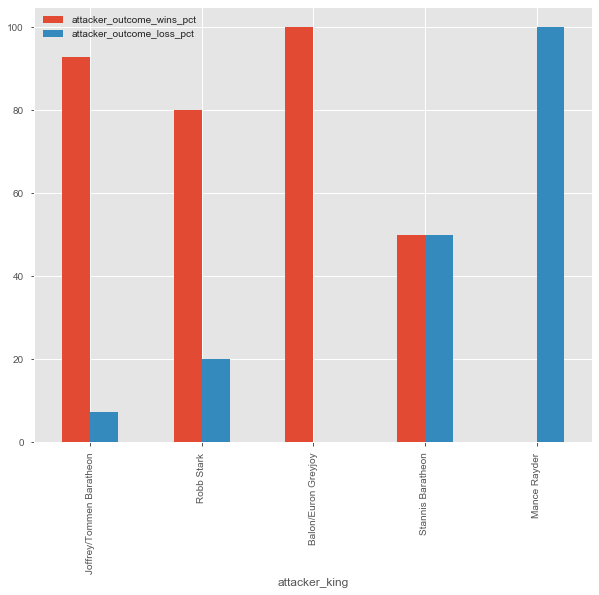

In [92]:
df_grouped[['attacker_king','attacker_outcome_wins_pct','attacker_outcome_loss_pct']].plot.bar(x='attacker_king')

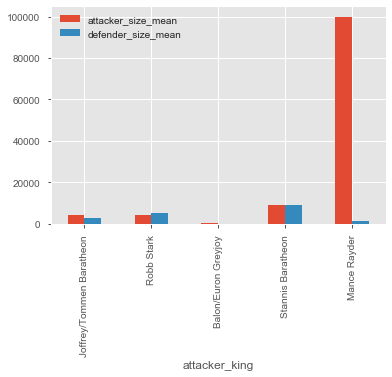

In [22]:
df_grouped[['attacker_king','attacker_size_mean','defender_size_mean']].plot.bar(x='attacker_king')

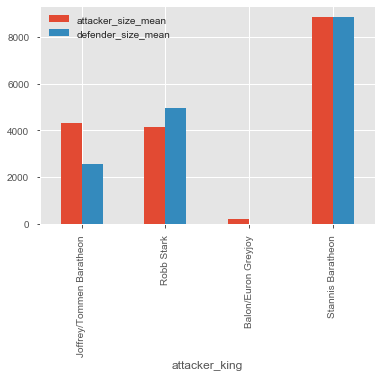

In [23]:
# Remove Mance Rayder
df_grouped[['attacker_king','attacker_size_mean','defender_size_mean']][df_grouped.attacker_king != 'Mance Rayder'].plot.bar(x='attacker_king')

## Battle year

year  battles  major_death  major_capture
0   298        7          4.0            3.0
1   299       20          8.0            6.0
2   300       11          1.0            2.0

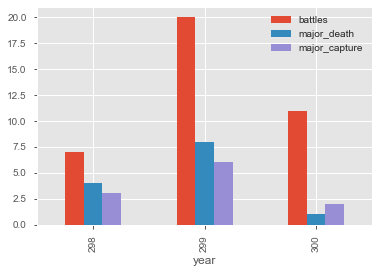

In [24]:
df_year = battles_df.groupby(by=['year']).agg(
    battles = ('name','count'),
    major_death = ('major_death', 'sum'),
    major_capture = ('major_capture','sum')).reset_index().sort_values(by = 'year', ascending = True)
    
df_year.plot.bar(x='year')
display(df_year)

## Battle vs Region

region  battles_count  major_death  major_capture
4   The Riverlands             17          6.0            6.0
2        The North             10          1.0            2.0
5   The Stormlands              3          1.0            0.0
6  The Westerlands              3          2.0            1.0
1   The Crownlands              2          2.0            1.0
3        The Reach              2          0.0            0.0
0  Beyond the Wall              1          1.0            1.0

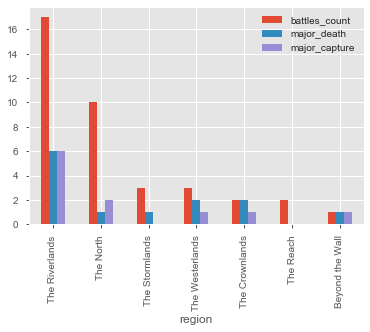

In [25]:
df_region = battles_df.groupby(by=['region']).agg(
    battles_count = ('name','count'),
    major_death = ('major_death', 'sum'),
    major_capture = ('major_capture','sum')).reset_index().sort_values(by = 'battles_count', ascending = False)
    
df_region.plot.bar(x='region')
display(df_region)

## Battle_Type vs Kings

battle_type  battles_count  major_death  major_capture
1  pitched battle             14          5.0            3.0
3           siege             12          2.0            4.0
0          ambush             10          6.0            4.0
2          razing              2          0.0            0.0

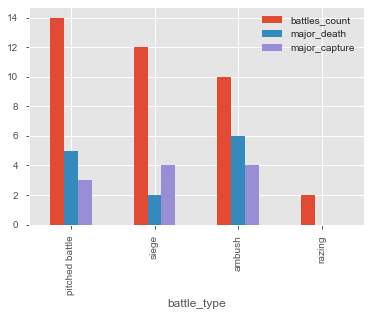

In [26]:
df_battle_type = battles_df.groupby(by=['battle_type']).agg(
    battles_count = ('name','count'),
    major_death = ('major_death', 'sum'),
    major_capture = ('major_capture','sum')).reset_index().sort_values(by = 'battles_count', ascending = False)
    
df_battle_type.plot.bar(x='battle_type')
display(df_battle_type)

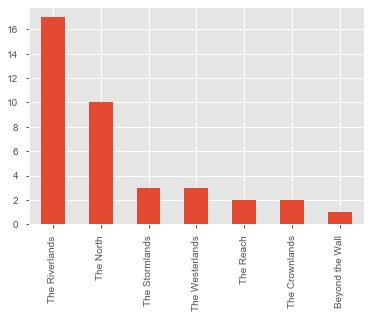

In [27]:
pd.value_counts(battles_df['region']).plot.bar()

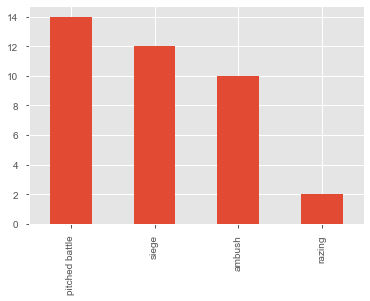

In [28]:
pd.value_counts(battles_df['battle_type']).plot.bar()

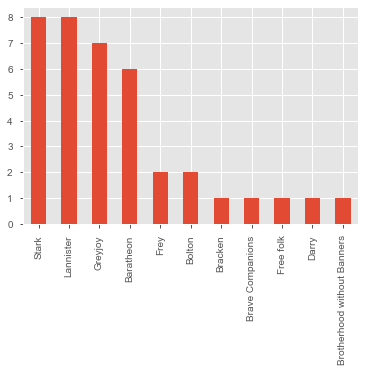

In [29]:
pd.value_counts(battles_df['attacker_1']).plot.bar()

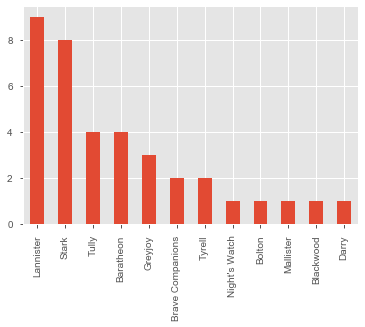

In [30]:
pd.value_counts(battles_df['defender_1']).plot.bar()


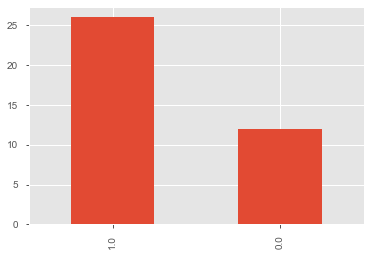

In [31]:
pd.value_counts(battles_df['summer']).plot.bar()

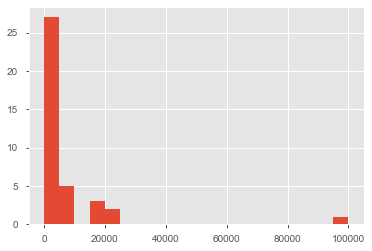

In [32]:
battles_df['attacker_size'].hist(bins=20)

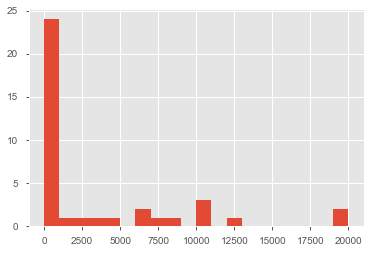

In [33]:
battles_df['defender_size'].hist(bins=20)

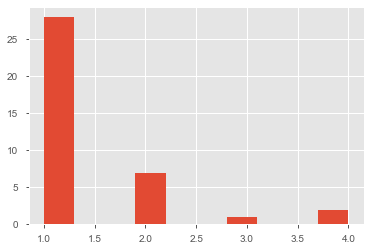

In [34]:
battles_df['attack_houses'].hist(bins=10)

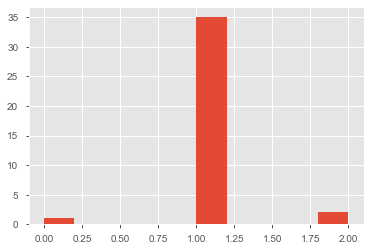

In [35]:
battles_df['defender_houses'].hist(bins=10)

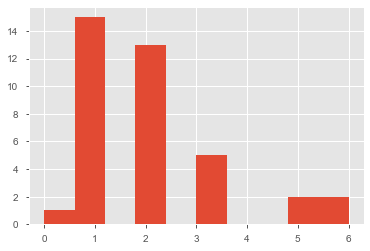

In [36]:
battles_df['attacker_commander_count'].hist(bins=10)

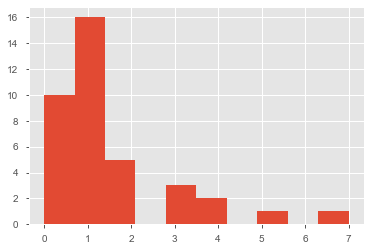

In [37]:
battles_df['defender_commander_count'].hist(bins=10)

## battle_type vs attacker_outcome

In [38]:
df_battle_type = battles_df.groupby(by=['battle_type']).agg(
    battles_count = ('name','count'),
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    defender_size_mean = ('defender_size','mean')).reset_index().sort_values(by = 'battles_count', ascending = False)

df_battle_type['attacker_outcome_loss'] = df_battle_type['attacker_outcome_flag_count'] - df_battle_type['attacker_outcome_wins']
df_battle_type['attacker_outcome_wins_pct'] = (df_battle_type['attacker_outcome_wins']/df_battle_type['attacker_outcome_flag_count']) * 100
df_battle_type['attacker_outcome_loss_pct'] = 100 - df_battle_type['attacker_outcome_wins_pct']
df_battle_type

battle_type  battles_count  attacker_outcome_flag_count  \
1  pitched battle             14                           14   
3           siege             12                           12   
0          ambush             10                           10   
2          razing              2                            2   

   attacker_outcome_wins  attacker_size_mean  defender_size_mean  \
1                   10.0         6910.285714         4167.857143   
3                   10.0         9791.666667         2453.333333   
0                   10.0         2437.700000         3434.500000   
2                    2.0            0.000000            0.000000   

   attacker_outcome_loss  attacker_outcome_wins_pct  attacker_outcome_loss_pct  
1                    4.0                  71.428571                  28.571429  
3                    2.0                  83.333333                  16.666667  
0                    0.0                 100.000000                   0.000000  
2                    0.0                 100.000000                   0.000000

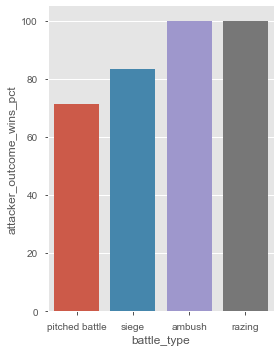

In [39]:
sns.factorplot(x="battle_type", y="attacker_outcome_wins_pct",
            aspect=0.8,
            kind="bar", data=df_battle_type)

## Summer vs battle_type vs attacker_outcome

In [40]:
df_battle_type_summer = battles_df.groupby(by=['summer','battle_type','attacker_outcome']).agg(
    battles_count = ('name','count'),
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    defender_size_mean = ('defender_size','mean')).reset_index().sort_values(by = 'battles_count', ascending = False)

df_battle_type_summer['attacker_outcome_loss'] = df_battle_type_summer['attacker_outcome_flag_count'] - df_battle_type_summer['attacker_outcome_wins']
df_battle_type_summer['attacker_outcome_wins_pct'] = (df_battle_type_summer['attacker_outcome_wins']/df_battle_type_summer['attacker_outcome_flag_count']) * 100
df_battle_type_summer['attacker_outcome_loss_pct'] = 100 - df_battle_type_summer['attacker_outcome_wins_pct']
df_battle_type_summer

summer     battle_type attacker_outcome  battles_count  \
4     1.0          ambush              win             10   
6     1.0  pitched battle              win              7   
3     0.0           siege              win              5   
7     1.0           siege              win              5   
5     1.0  pitched battle             loss              4   
0     0.0  pitched battle              win              3   
1     0.0          razing              win              2   
2     0.0           siege             loss              1   

   attacker_outcome_flag_count  attacker_outcome_wins  attacker_size_mean  \
4                           10                   10.0         2437.700000   
6                            7                    7.0         4320.571429   
3                            5                    5.0         1300.000000   
7                            5                    5.0         1200.000000   
5                            4                    0.0        15500.000000   
0                            3                    3.0         1500.000000   
1                            2                    2.0            0.000000   
2                            1                    0.0       100000.000000   

   defender_size_mean  attacker_outcome_loss  attacker_outcome_wins_pct  \
4         3434.500000                    0.0                      100.0   
6         2128.571429                    0.0                      100.0   
3           40.000000                    0.0                      100.0   
7         4000.000000                    0.0                      100.0   
5         9312.500000                    4.0                        0.0   
0         2066.666667                    0.0                      100.0   
1            0.000000                    0.0                      100.0   
2         1240.000000                    1.0                        0.0   

   attacker_outcome_loss_pct  
4                        0.0  
6                        0.0  
3                        0.0  
7                        0.0  
5                      100.0  
0                        0.0  
1                        0.0  
2                      100.0

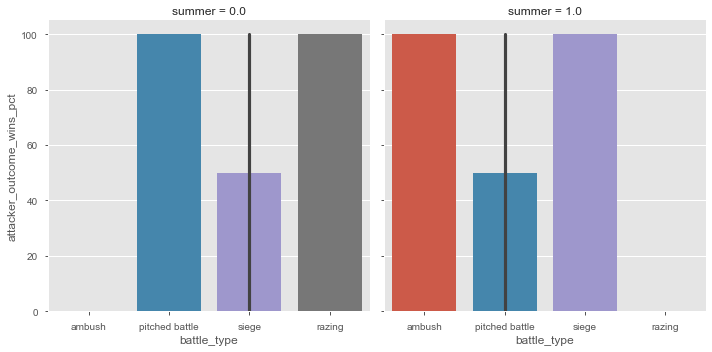

In [41]:
sns.factorplot(x="battle_type", y="attacker_outcome_wins_pct",
            col="summer", aspect=1,
            kind="bar", data=df_battle_type_summer)

## battle_type vs. attacker_king

In [42]:
df_battle_attacker_king = battles_df.groupby(by=['attacker_king','battle_type']).agg(
    battles_count = ('name','count'),
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    defender_size_mean = ('defender_size','mean')).reset_index().sort_values(by = 'battles_count', ascending = False)

df_battle_attacker_king['attacker_outcome_loss'] = df_battle_attacker_king['attacker_outcome_flag_count'] - df_battle_attacker_king['attacker_outcome_wins']
df_battle_attacker_king['attacker_outcome_wins_pct'] = (df_battle_attacker_king['attacker_outcome_wins']/df_battle_attacker_king['attacker_outcome_flag_count']) * 100
df_battle_attacker_king['attacker_outcome_loss_pct'] = 100 - df_battle_attacker_king['attacker_outcome_wins_pct']
df_battle_attacker_king

attacker_king     battle_type  battles_count  \
5   Joffrey/Tommen Baratheon  pitched battle              6   
6   Joffrey/Tommen Baratheon           siege              5   
8                 Robb Stark          ambush              5   
4   Joffrey/Tommen Baratheon          ambush              3   
9                 Robb Stark  pitched battle              3   
0        Balon/Euron Greyjoy          ambush              2   
1        Balon/Euron Greyjoy  pitched battle              2   
3        Balon/Euron Greyjoy           siege              2   
10                Robb Stark           siege              2   
11         Stannis Baratheon  pitched battle              2   
12         Stannis Baratheon           siege              2   
2        Balon/Euron Greyjoy          razing              1   
7               Mance Rayder           siege              1   

    attacker_outcome_flag_count  attacker_outcome_wins  attacker_size_mean  \
5                             6                    5.0         8333.333333   
6                             5                    5.0         1300.000000   
8                             5                    5.0         3995.000000   
4                             3                    3.0         1372.666667   
9                             3                    1.0         7081.333333   
0                             2                    2.0          142.000000   
1                             2                    2.0            0.000000   
3                             2                    2.0          500.000000   
10                            2                    2.0            0.000000   
11                            2                    1.0        12750.000000   
12                            2                    1.0         5000.000000   
2                             1                    1.0            0.000000   
7                             1                    0.0       100000.000000   

    defender_size_mean  attacker_outcome_loss  attacker_outcome_wins_pct  \
5          5000.000000                    1.0                  83.333333   
6            40.000000                    0.0                 100.000000   
8          5745.000000                    0.0                 100.000000   
4          1873.333333                    0.0                 100.000000   
9          6966.666667                    2.0                  33.333333   
0             0.000000                    0.0                 100.000000   
1             0.000000                    0.0                 100.000000   
3             0.000000                    0.0                 100.000000   
10            0.000000                    0.0                 100.000000   
11         3725.000000                    1.0                  50.000000   
12        14000.000000                    1.0                  50.000000   
2             0.000000                    0.0                 100.000000   
7          1240.000000                    1.0                   0.000000   

    attacker_outcome_loss_pct  
5                   16.666667  
6                    0.000000  
8                    0.000000  
4                    0.000000  
9                   66.666667  
0                    0.000000  
1                    0.000000  
3                    0.000000  
10                   0.000000  
11                  50.000000  
12                  50.000000  
2                    0.000000  
7                  100.000000

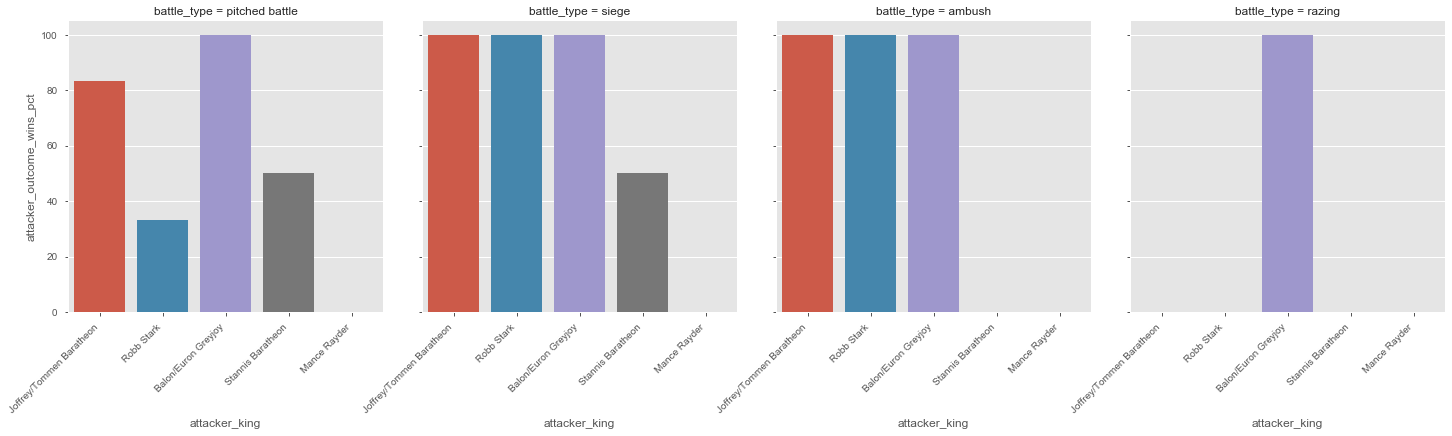

In [43]:
chart = sns.catplot(x="attacker_king", y="attacker_outcome_wins_pct",
                       col="battle_type", aspect=1,
                       kind="bar", data=df_battle_attacker_king)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

## battle_type vs. defender_king

In [44]:
df_battle_defender_king = battles_df.groupby(by=['defender_king','battle_type']).agg(
    battles_count = ('name','count'),
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    defender_size_mean = ('defender_size','mean')).reset_index().sort_values(by = 'battles_count', ascending = False)

df_battle_defender_king['attacker_outcome_loss'] = df_battle_defender_king['attacker_outcome_flag_count'] - df_battle_defender_king['attacker_outcome_wins']
df_battle_defender_king['attacker_outcome_wins_pct'] = (df_battle_defender_king['attacker_outcome_wins']/df_battle_defender_king['attacker_outcome_flag_count']) * 100
df_battle_defender_king['attacker_outcome_loss_pct'] = 100 - df_battle_defender_king['attacker_outcome_wins_pct']
df_battle_defender_king

defender_king     battle_type  battles_count  \
8                 Robb Stark  pitched battle              6   
2   Joffrey/Tommen Baratheon          ambush              5   
7                 Robb Stark          ambush              5   
3   Joffrey/Tommen Baratheon  pitched battle              4   
5   Joffrey/Tommen Baratheon           siege              3   
9                 Robb Stark           siege              3   
10         Stannis Baratheon           siege              3   
0        Balon/Euron Greyjoy  pitched battle              2   
1        Balon/Euron Greyjoy           siege              2   
4   Joffrey/Tommen Baratheon          razing              1   
6            Renly Baratheon           siege              1   

    attacker_outcome_flag_count  attacker_outcome_wins  attacker_size_mean  \
8                             6                    5.0         8333.333333   
2                             5                    5.0         3995.000000   
7                             5                    5.0          880.400000   
3                             4                    1.0        10500.000000   
5                             3                    2.0         1666.666667   
9                             3                    3.0         1833.333333   
10                            3                    2.0        34000.000000   
0                             2                    2.0         2372.000000   
1                             2                    2.0            0.000000   
4                             1                    1.0            0.000000   
6                             1                    1.0         5000.000000   

    defender_size_mean  attacker_outcome_loss  attacker_outcome_wins_pct  \
8          5000.000000                    1.0                  83.333333   
2          5745.000000                    0.0                 100.000000   
7          1124.000000                    0.0                 100.000000   
3          6812.500000                    3.0                  25.000000   
5          2666.666667                    1.0                  66.666667   
9             0.000000                    0.0                 100.000000   
10          480.000000                    1.0                  66.666667   
0           550.000000                    0.0                 100.000000   
1             0.000000                    0.0                 100.000000   
4             0.000000                    0.0                 100.000000   
6         20000.000000                    0.0                 100.000000   

    attacker_outcome_loss_pct  
8                   16.666667  
2                    0.000000  
7                    0.000000  
3                   75.000000  
5                   33.333333  
9                    0.000000  
10                  33.333333  
0                    0.000000  
1                    0.000000  
4                    0.000000  
6                    0.000000

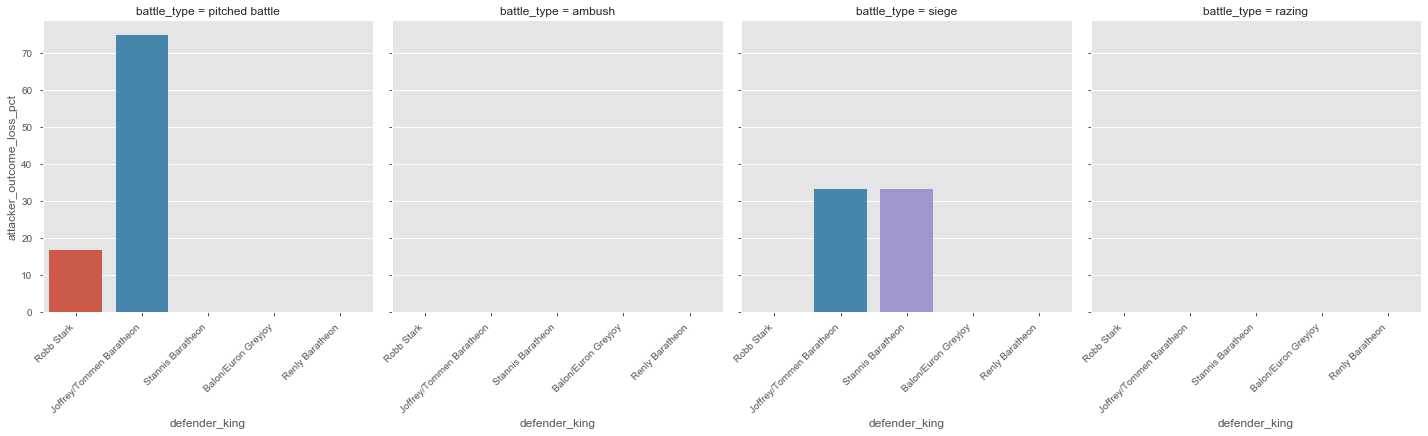

In [45]:
chart = sns.catplot(x="defender_king", y="attacker_outcome_loss_pct",
                       col="battle_type", aspect=1,
                       kind="bar", data=df_battle_defender_king)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

## attacker_king vs defender_king

In [46]:
df_attack_defend = battles_df.groupby(by=['attacker_king','defender_king']).agg(
    battles_count = ('name','count'),
    attacker_outcome_flag_count = ('attacker_outcome_flag','count'),
    attacker_outcome_wins = ('attacker_outcome_flag','sum'),
    attacker_size_mean = ('attacker_size', 'mean'),
    defender_size_mean = ('defender_size','mean')).reset_index().sort_values(by = 'battles_count', ascending = False)

df_attack_defend['attacker_outcome_loss'] = df_attack_defend['attacker_outcome_flag_count'] - df_attack_defend['attacker_outcome_wins']
df_attack_defend['attacker_outcome_wins_pct'] = (df_attack_defend['attacker_outcome_wins']/df_attack_defend['attacker_outcome_flag_count']) * 100
df_attack_defend['attacker_outcome_loss_pct'] = 100 - df_attack_defend['attacker_outcome_wins_pct']
df_attack_defend

attacker_king             defender_king  battles_count  \
4   Joffrey/Tommen Baratheon                Robb Stark             10   
8                 Robb Stark  Joffrey/Tommen Baratheon              9   
2        Balon/Euron Greyjoy                Robb Stark              4   
1        Balon/Euron Greyjoy  Joffrey/Tommen Baratheon              2   
5   Joffrey/Tommen Baratheon         Stannis Baratheon              2   
10         Stannis Baratheon  Joffrey/Tommen Baratheon              2   
0        Balon/Euron Greyjoy       Balon/Euron Greyjoy              1   
3   Joffrey/Tommen Baratheon       Balon/Euron Greyjoy              1   
6               Mance Rayder         Stannis Baratheon              1   
7                 Robb Stark       Balon/Euron Greyjoy              1   
9          Stannis Baratheon       Balon/Euron Greyjoy              1   
11         Stannis Baratheon           Renly Baratheon              1   

    attacker_outcome_flag_count  attacker_outcome_wins  attacker_size_mean  \
4                            10                    9.0         5861.800000   
8                             9                    7.0         4552.777778   
2                             4                    4.0          321.000000   
1                             2                    2.0            0.000000   
5                             2                    2.0         1000.000000   
10                            2                    0.0        13000.000000   
0                             1                    1.0            0.000000   
3                             1                    1.0            0.000000   
6                             1                    0.0       100000.000000   
7                             1                    1.0          244.000000   
9                             1                    1.0         4500.000000   
11                            1                    1.0         5000.000000   

    defender_size_mean  attacker_outcome_loss  attacker_outcome_wins_pct  \
4          3562.000000                    1.0                  90.000000   
8          5413.888889                    2.0                  77.777778   
2             0.000000                    0.0                 100.000000   
1             0.000000                    0.0                 100.000000   
5           100.000000                    0.0                 100.000000   
10         7625.000000                    2.0                   0.000000   
0             0.000000                    0.0                 100.000000   
3             0.000000                    0.0                 100.000000   
6          1240.000000                    1.0                   0.000000   
7           900.000000                    0.0                 100.000000   
9           200.000000                    0.0                 100.000000   
11        20000.000000                    0.0                 100.000000   

    attacker_outcome_loss_pct  
4                   10.000000  
8                   22.222222  
2                    0.000000  
1                    0.000000  
5                    0.000000  
10                 100.000000  
0                    0.000000  
3                    0.000000  
6                  100.000000  
7                    0.000000  
9                    0.000000  
11                   0.000000

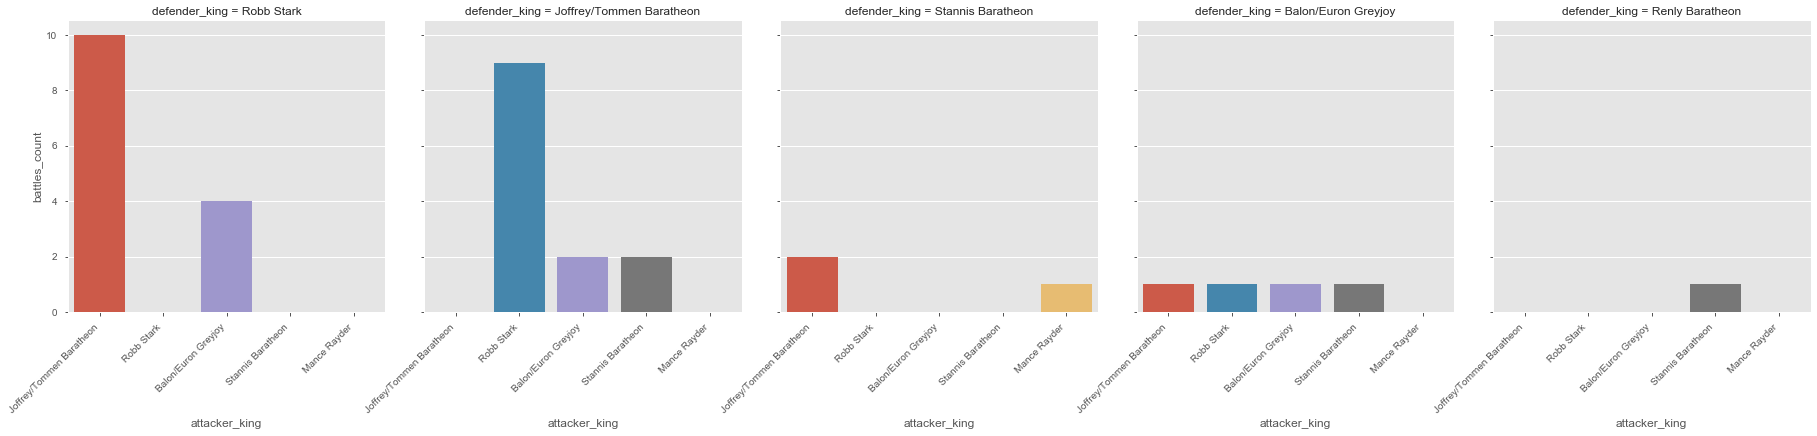

In [47]:
chart = sns.catplot(x="attacker_king", y="battles_count",
                       col="defender_king", aspect=1,
                       kind="bar", data=df_attack_defend)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

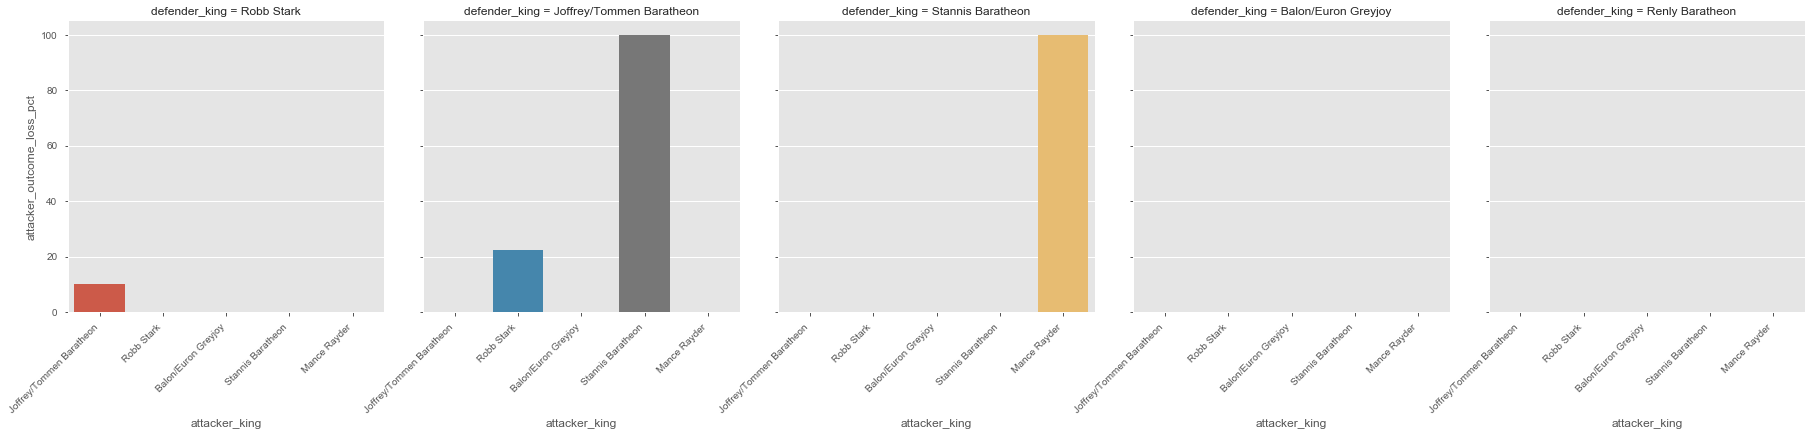

In [48]:
chart = sns.catplot(x="attacker_king", y="attacker_outcome_loss_pct",
                       col="defender_king", aspect=1,
                       kind="bar", data=df_attack_defend)
chart.set_xticklabels(rotation=45, horizontalalignment='right')


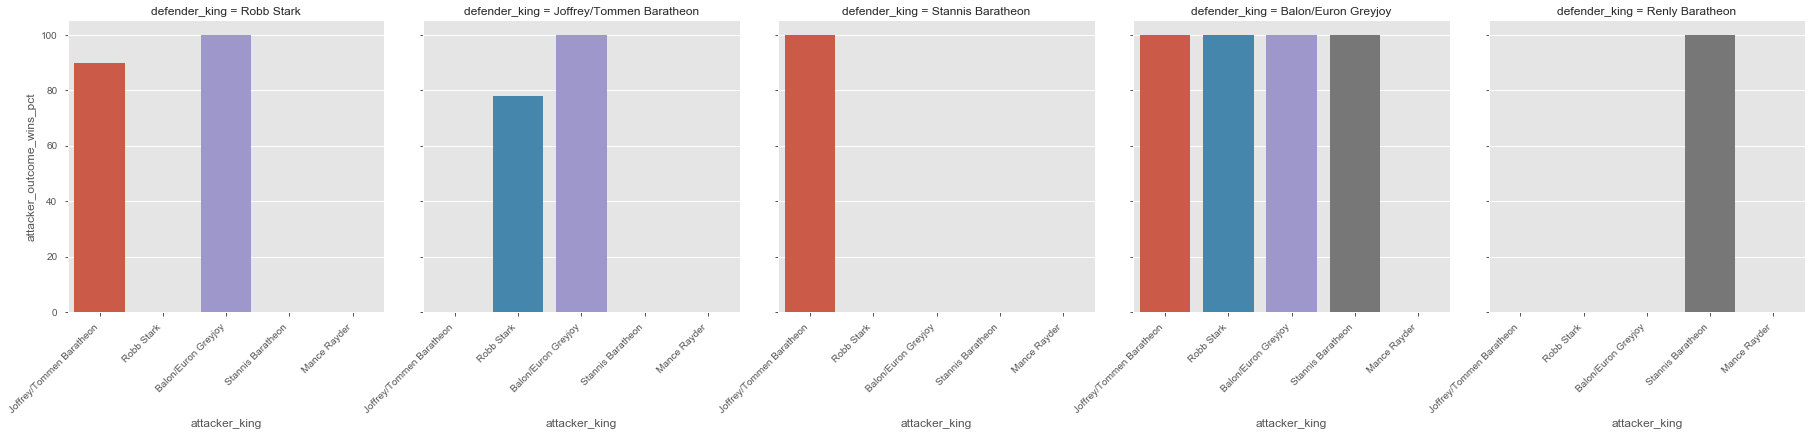

In [49]:
chart = sns.catplot(x="attacker_king", y="attacker_outcome_wins_pct",
                       col="defender_king", aspect=1,
                       kind="bar", data=df_attack_defend)
chart.set_xticklabels(rotation=45, horizontalalignment='right')

## Battle Size 

[Text(0, 0, 'Balon/Euron Greyjoy'),
 Text(0, 0, 'Robb Stark'),
 Text(0, 0, 'Joffrey/Tommen Baratheon'),
 Text(0, 0, 'Stannis Baratheon')]

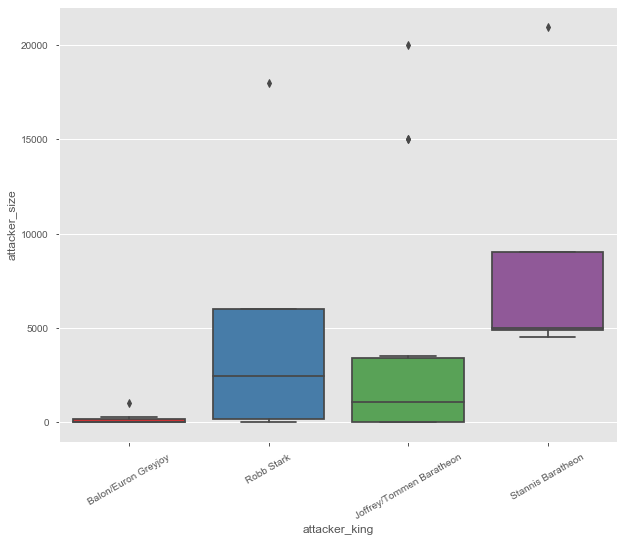

In [107]:
chart = sns.boxplot(x="attacker_king", y="attacker_size", data=battles_df[battles_df.attacker_king != 'Mance Rayder'], palette="Set1")
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

[Text(0, 0, 'Balon/Euron Greyjoy'),
 Text(0, 0, 'Robb Stark'),
 Text(0, 0, 'Joffrey/Tommen Baratheon'),
 Text(0, 0, 'Stannis Baratheon')]

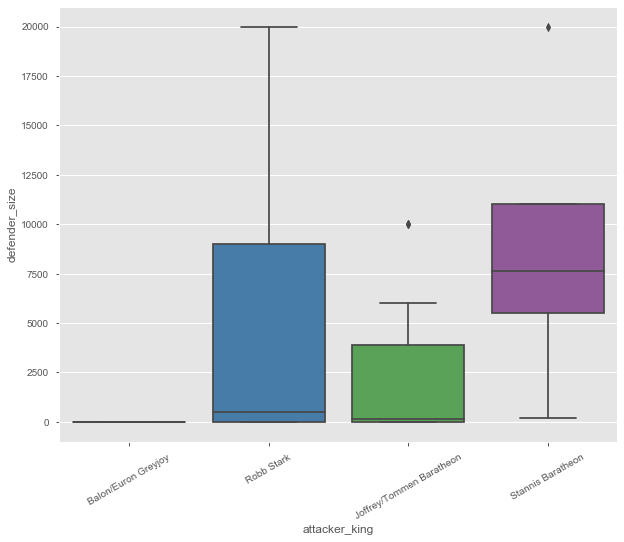

In [106]:
chart = sns.boxplot(x="attacker_king", y="defender_size", data=battles_df[battles_df.attacker_king != 'Mance Rayder'], palette="Set1")
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

[Text(0, 0, 'Balon/Euron Greyjoy'),
 Text(0, 0, 'Robb Stark'),
 Text(0, 0, 'Joffrey/Tommen Baratheon'),
 Text(0, 0, 'Stannis Baratheon')]

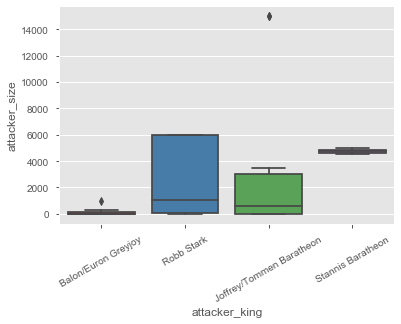

In [51]:
chart = sns.boxplot(x="attacker_king", y="attacker_size", data=battles_df[(battles_df.attacker_king != 'Mance Rayder') & (battles_df.attacker_outcome == 'win')], palette="Set1")
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

[Text(0, 0, 'Robb Stark'),
 Text(0, 0, 'Joffrey/Tommen Baratheon'),
 Text(0, 0, 'Stannis Baratheon')]

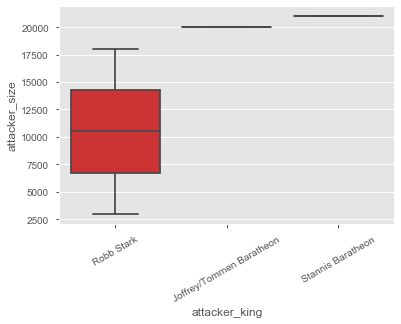

In [52]:
chart = sns.boxplot(x="attacker_king", y="attacker_size", data=battles_df[(battles_df.attacker_king != 'Mance Rayder') & (battles_df.attacker_outcome == 'loss')], palette="Set1")
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

# Start Modeling Here

There are two types of machine learning types that I will be performing:

1) Regression Model for `attacker_size` vs 'defender_size` to determine the army size a house will be fighting against

2) Classification Model - What factors determine the `attacker_outcome`?


## Regression Model

attacker_size  defender_size
attacker_size        1.00000        0.17306
defender_size        0.17306        1.00000

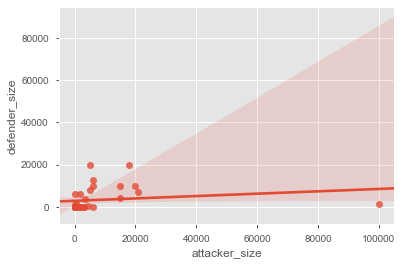

In [53]:
sns.regplot(x='attacker_size',y='defender_size',data=battles_df)
display(battles_df[['attacker_size','defender_size']].corr())

attacker_size  defender_size
attacker_size       1.000000       0.438731
defender_size       0.438731       1.000000

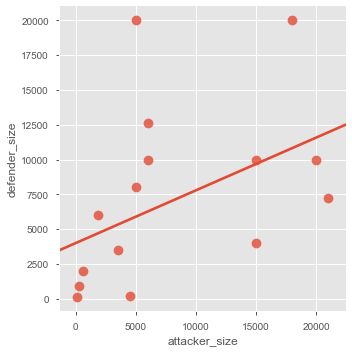

In [54]:
battles_df1 = battles_df[(battles_df.attacker_king != 'Mance Rayder') & (battles_df.attacker_size > 0) & (battles_df.defender_size > 0)]

sns.lmplot(x='attacker_size', y='defender_size', data=battles_df1[['attacker_size','defender_size']],
           robust=True, ci=None, scatter_kws={"s": 95})
display(battles_df1[['attacker_size','defender_size']].corr())

attacker_size  defender_size
attacker_size       1.000000       0.758063
defender_size       0.758063       1.000000

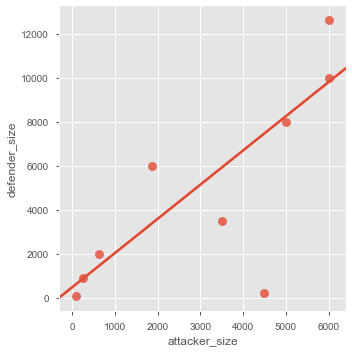

In [55]:
battles_df1 = battles_df[(battles_df.attacker_king != 'Mance Rayder') & (battles_df.attacker_size > 0) & (battles_df.defender_size > 0)& (battles_df.attacker_size < 14000) & (battles_df.defender_size < 20000)]
sns.lmplot(x='attacker_size', y='defender_size', data=battles_df1[['attacker_size','defender_size']],
           robust=True, ci=None, scatter_kws={"s": 80})
display(battles_df1[['attacker_size','defender_size']].corr())

attacker_size  defender_size
attacker_size       1.000000       0.738457
defender_size       0.738457       1.000000

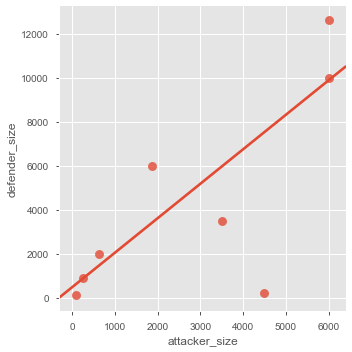

In [56]:
battles_df1 = battles_df[(battles_df.attacker_king != 'Mance Rayder') & (battles_df.attacker_outcome_flag == 1) & (battles_df.attacker_size > 0) & (battles_df.defender_size > 0) & (battles_df.attacker_size < 14000) & (battles_df.defender_size < 20000)]
sns.lmplot(x='attacker_size', y='defender_size', data=battles_df1[['attacker_size','defender_size']],
           robust=True, ci=None, scatter_kws={"s": 80})
display(battles_df1[['attacker_size','defender_size']].corr())

attacker_size  defender_size
attacker_size       1.000000       0.738457
defender_size       0.738457       1.000000

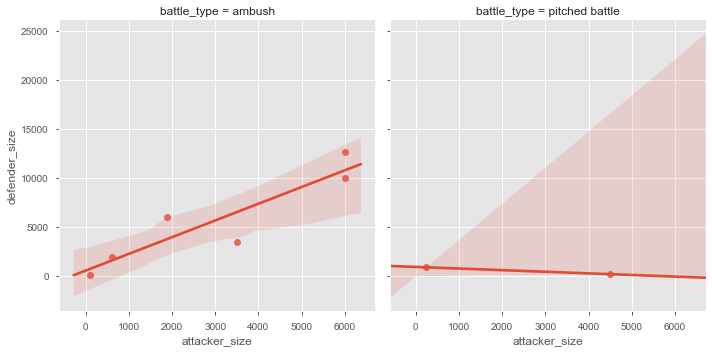

In [57]:
sns.lmplot(x='attacker_size', y='defender_size', data=battles_df1[(battles_df.battle_type != 'NaN')], col = "battle_type",palette="Set1")
display(battles_df1[['attacker_size','defender_size']].corr())

In [58]:
battle_type_list = battles_df1['battle_type'].unique()
for i in range(len(battle_type_list)):
    print('battle_type = ' +  battle_type_list[i])
    display(battles_df1.loc[battles_df['battle_type'] == battle_type_list[i],['attacker_size','defender_size']].corr())

battle_type = ambush


attacker_size  defender_size
attacker_size       1.000000       0.916012
defender_size       0.916012       1.000000

battle_type = pitched battle


attacker_size  defender_size
attacker_size            1.0           -1.0
defender_size           -1.0            1.0

In [59]:
def scatter_plotter(df,x,y):
    ''' Creates a scatter plot with the independent and dependent variables 
    with the ability to scale and remove outliers.
    
    :param df: dataframe
    :param x: independent variable
    :param y: dependent variable 
    '''    
    df = df[(df[x] > 0)&(df[y]>0)].dropna()
    battle_type_list = df['battle_type'].unique()
    for i in range(len(battle_type_list)):
        fig = px.scatter(df[(df.battle_type == battle_type_list[i])], x=x, y=y, 
                         hover_name="name",
                         hover_data=["name","year","attacker_outcome","attacker_king", "defender_king"],
                         trendline="ols")
        fig.update_layout(title= str(x) + ' vs ' + str(y) + ' - ' + str(battle_type_list[i]))
        fig.show()

In [60]:
scatter_plotter(battles_df1,'attacker_size','defender_size')

## Classification Modeling

In [61]:
 # Drop columns with missing data
model_df = battles_df.drop(columns = ['name','location','attacker_commander','defender_commander','attacker_outcome','attacker_outcome_flag','battle_size'])
attacker_outcome = battles_df['attacker_outcome_flag']

In [62]:
model_df.dtypes

year                          int64
attacker_king                object
defender_king                object
attacker_1                   object
defender_1                   object
battle_type                  object
major_death                 float64
major_capture               float64
attacker_size               float64
defender_size               float64
summer                      float64
region                       object
attack_houses                 int64
defender_houses               int64
attacker_commander_count      int64
defender_commander_count      int64
dtype: object

In [63]:
model_df[model_df.columns[0:10]].head()

year             attacker_king             defender_king attacker_1  \
0   299       Balon/Euron Greyjoy                Robb Stark    Greyjoy   
1   299                Robb Stark  Joffrey/Tommen Baratheon      Stark   
2   299                Robb Stark       Balon/Euron Greyjoy      Stark   
3   299       Balon/Euron Greyjoy                Robb Stark    Greyjoy   
4   299  Joffrey/Tommen Baratheon                Robb Stark     Bolton   

  defender_1     battle_type  major_death  major_capture  attacker_size  \
0      Stark          ambush          0.0            1.0           20.0   
1  Lannister          ambush          1.0            0.0          100.0   
2    Greyjoy  pitched battle          0.0            0.0          244.0   
3      Stark          ambush          0.0            0.0          264.0   
4      Stark          ambush          1.0            0.0          618.0   

   defender_size  
0            0.0  
1          100.0  
2          900.0  
3            0.0  
4         2000.0

In [64]:
model_df[model_df.columns[11:23]].head()

region  attack_houses  defender_houses  attacker_commander_count  \
0       The North              1                1                         1   
1  The Riverlands              1                1                         3   
2       The North              1                1                         2   
3       The North              1                1                         1   
4       The North              2                1                         2   

   defender_commander_count  
0                         1  
1                         1  
2                         1  
3                         0  
4                         3

In [65]:
model_df[['attacker_king','defender_king','attacker_1','defender_1']] = model_df[['attacker_king','defender_king','attacker_1','defender_1']].replace('/','_',regex=True)
model_df[['attacker_king','defender_king','region','battle_type','attacker_1','defender_1']] = model_df[['attacker_king','defender_king','region','battle_type','attacker_1','defender_1']].replace(' ','_',regex=True)
model_df[model_df.columns[0:10]].head()

year             attacker_king             defender_king attacker_1  \
0   299       Balon_Euron_Greyjoy                Robb_Stark    Greyjoy   
1   299                Robb_Stark  Joffrey_Tommen_Baratheon      Stark   
2   299                Robb_Stark       Balon_Euron_Greyjoy      Stark   
3   299       Balon_Euron_Greyjoy                Robb_Stark    Greyjoy   
4   299  Joffrey_Tommen_Baratheon                Robb_Stark     Bolton   

  defender_1     battle_type  major_death  major_capture  attacker_size  \
0      Stark          ambush          0.0            1.0           20.0   
1  Lannister          ambush          1.0            0.0          100.0   
2    Greyjoy  pitched_battle          0.0            0.0          244.0   
3      Stark          ambush          0.0            0.0          264.0   
4      Stark          ambush          1.0            0.0          618.0   

   defender_size  
0            0.0  
1          100.0  
2          900.0  
3            0.0  
4         2000.0

In [66]:
model_df[model_df.columns[10:24]].head()

summer          region  attack_houses  defender_houses  \
0     1.0       The_North              1                1   
1     1.0  The_Riverlands              1                1   
2     1.0       The_North              1                1   
3     1.0       The_North              1                1   
4     1.0       The_North              2                1   

   attacker_commander_count  defender_commander_count  
0                         1                         1  
1                         3                         1  
2                         2                         1  
3                         1                         0  
4                         2                         3

In [67]:
categorical_feature_mask = model_df.dtypes==object
categorical_cols = model_df.columns[categorical_feature_mask].tolist()
categorical_cols

['attacker_king',
 'defender_king',
 'attacker_1',
 'defender_1',
 'battle_type',
 'region']

In [68]:
model_df1 = pd.get_dummies(model_df, columns=categorical_cols, prefix = categorical_cols)
model_df1.head()

year  major_death  major_capture  attacker_size  defender_size  summer  \
0   299          0.0            1.0           20.0            0.0     1.0   
1   299          1.0            0.0          100.0          100.0     1.0   
2   299          0.0            0.0          244.0          900.0     1.0   
3   299          0.0            0.0          264.0            0.0     1.0   
4   299          1.0            0.0          618.0         2000.0     1.0   

   attack_houses  defender_houses  attacker_commander_count  \
0              1                1                         1   
1              1                1                         3   
2              1                1                         2   
3              1                1                         1   
4              2                1                         2   

   defender_commander_count  ...  battle_type_pitched_battle  \
0                         1  ...                           0   
1                         1  ...                           0   
2                         1  ...                           1   
3                         0  ...                           0   
4                         3  ...                           0   

   battle_type_razing  battle_type_siege  region_Beyond_the_Wall  \
0                   0                  0                       0   
1                   0                  0                       0   
2                   0                  0                       0   
3                   0                  0                       0   
4                   0                  0                       0   

   region_The_Crownlands  region_The_North  region_The_Reach  \
0                      0                 1                 0   
1                      0                 0                 0   
2                      0                 1                 0   
3                      0                 1                 0   
4                      0                 1                 0   

   region_The_Riverlands  region_The_Stormlands  region_The_Westerlands  
0                      0                      0                       0  
1                      1                      0                       0  
2                      0                      0                       0  
3                      0                      0                       0  
4                      0                      0                       0  

[5 rows x 54 columns]

In [69]:
model_df1.columns

Index(['year', 'major_death', 'major_capture', 'attacker_size',
       'defender_size', 'summer', 'attack_houses', 'defender_houses',
       'attacker_commander_count', 'defender_commander_count',
       'attacker_king_Balon_Euron_Greyjoy',
       'attacker_king_Joffrey_Tommen_Baratheon', 'attacker_king_Mance_Rayder',
       'attacker_king_Robb_Stark', 'attacker_king_Stannis_Baratheon',
       'defender_king_Balon_Euron_Greyjoy',
       'defender_king_Joffrey_Tommen_Baratheon',
       'defender_king_Renly_Baratheon', 'defender_king_Robb_Stark',
       'defender_king_Stannis_Baratheon', 'attacker_1_Baratheon',
       'attacker_1_Bolton', 'attacker_1_Bracken',
       'attacker_1_Brave_Companions', 'attacker_1_Brotherhood_without_Banners',
       'attacker_1_Darry', 'attacker_1_Free_folk', 'attacker_1_Frey',
       'attacker_1_Greyjoy', 'attacker_1_Lannister', 'attacker_1_Stark',
       'defender_1_Baratheon', 'defender_1_Blackwood', 'defender_1_Bolton',
       'defender_1_Brave_Companion

## Log transform `defender_size` and `attacker_size`  


In [70]:
# Log-transform the skewed features
skewed = ['attacker_size', 'defender_size']
features_log_transformed = pd.DataFrame(data = model_df1)
features_log_transformed[skewed] = model_df1[skewed].apply(lambda x: np.log(x + 1))

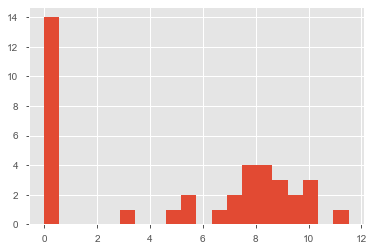

In [71]:
features_log_transformed['attacker_size'].hist(bins=20)

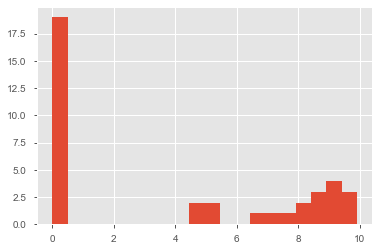

In [72]:
features_log_transformed['defender_size'].hist(bins=20)

## Normalizing Numerical Features

In [73]:

# attack_houses,defender_houses,attacker_commander_count,defender_commander_count,attacker_size,defender_size
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['attack_houses','defender_houses','attacker_commander_count','defender_commander_count','attacker_size','defender_size']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

year  major_death  major_capture  attacker_size  defender_size  summer  \
0   299          0.0            1.0       0.264444       0.000000     1.0   
1   299          1.0            0.0       0.400864       0.466007     1.0   
2   299          0.0            0.0       0.477833       0.686977     1.0   
3   299          0.0            0.0       0.484649       0.000000     1.0   
4   299          1.0            0.0       0.558338       0.767544     1.0   

   attack_houses  defender_houses  attacker_commander_count  \
0       0.000000              0.5                  0.166667   
1       0.000000              0.5                  0.500000   
2       0.000000              0.5                  0.333333   
3       0.000000              0.5                  0.166667   
4       0.333333              0.5                  0.333333   

   defender_commander_count  ...  battle_type_pitched_battle  \
0                  0.142857  ...                           0   
1                  0.142857  ...                           0   
2                  0.142857  ...                           1   
3                  0.000000  ...                           0   
4                  0.428571  ...                           0   

   battle_type_razing  battle_type_siege  region_Beyond_the_Wall  \
0                   0                  0                       0   
1                   0                  0                       0   
2                   0                  0                       0   
3                   0                  0                       0   
4                   0                  0                       0   

   region_The_Crownlands  region_The_North  region_The_Reach  \
0                      0                 1                 0   
1                      0                 0                 0   
2                      0                 1                 0   
3                      0                 1                 0   
4                      0                 1                 0   

   region_The_Riverlands  region_The_Stormlands  region_The_Westerlands  
0                      0                      0                       0  
1                      1                      0                       0  
2                      0                      0                       0  
3                      0                      0                       0  
4                      0                      0                       0  

[5 rows x 54 columns]

In [74]:
features_final = features_log_transformed
features_final.to_csv('../data/battles_data_model.csv',index = False)

## Shuffle and split data

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    attacker_outcome, 
                                                    random_state = 0,
                                                    test_size = 0.25)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28 samples.
Testing set has 10 samples.


## Model Selection

* Logistic Regression  

* Random Forest

* XG Boost




## Logistic Regression

In [76]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
display(accuracies.mean())
display(accuracies.std())

0.9166666666666666

0.2327373340628157

The accuracy using logistic regression is 91.6% with a standard deviation of 0.2327 and we have a good baseline classification model already which is good news.

## Random Forest

In [77]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy',random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
display(accuracies.mean())
display(accuracies.std())

0.95

0.11902380714238082

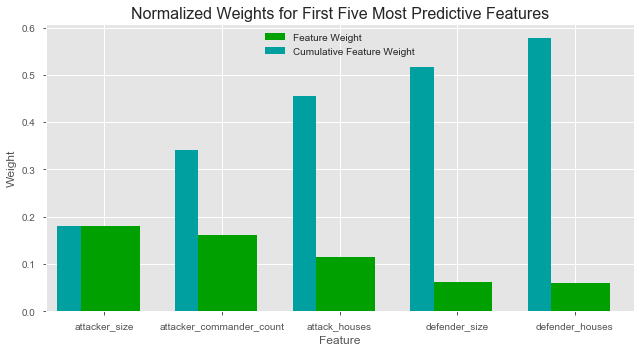

In [78]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = classifier.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

The accuracy using random forest is 95.0% with a standard deviation of 0.119. The accuracy improved by approximately 3.6% and the standard deviation decreased by almost half.

## XGBoost

In [79]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
display(accuracies.mean())
display(accuracies.std())

0.925

0.15343293866268307

Surprisingly, XGBoost has the worst accuracy compared to the Logistic Regression and Random Forest models (90%) but it is still a good model.

Random Forest has the best accuracy of 95%. The features importance are `attacker_size`, `attacker_commander_count`,`attack_houses`,`defender_size`, and `defender_houses`.

## Implementation - Extracting Feature Importance

In [80]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy',random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
display(accuracies.mean())
display(accuracies.std())

0.95

0.11902380714238082

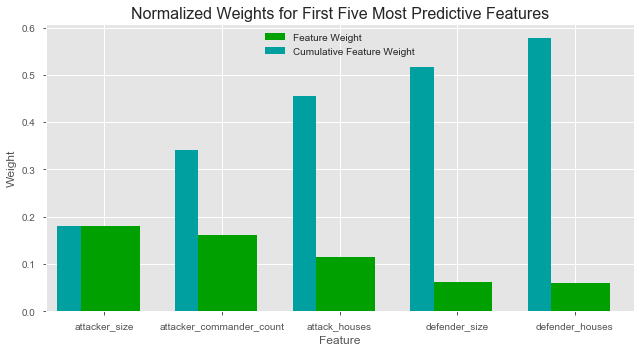

In [81]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = classifier.feature_importances_
vs.feature_plot(importances, X_train, y_train)

In [82]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = classifier.fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_reduced, y = y_train, cv = 20)
display(accuracies.mean())
display(accuracies.std())

0.9666666666666666

0.1

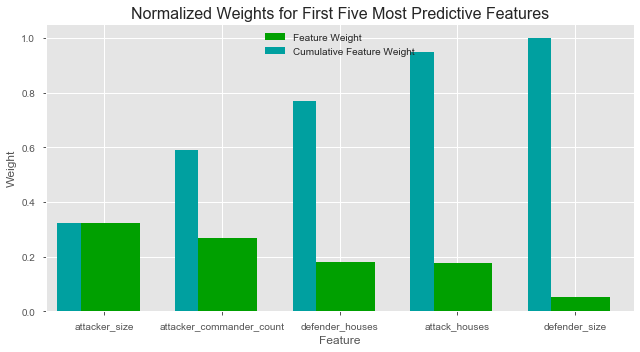

In [83]:
importances = clf.feature_importances_
vs.feature_plot(importances, X_train_reduced, y_train)

After we reduced the features down to the 5 most significant predictors, we get a slight improvement in accuracy of 96.6% and the standard deviation decreased slightly to 0.1. This is okay as we now have a model that can predict battle outcomes for Game of Thrones!

The most important factors are:

`attacker_size` - The size of the attacking house matter (unless you are Balon/Euron Greyjoy who wins with smaller armies)  
`attacker_commander_count` - The count of the attacker commander matters as well.  
`attack_houses`  - The number of attacking houses that are in the battle.  
`defender_size`  - The size of the defender house matter (unless you are Balon/Euron Greyjoy who wins with smaller armies)  
`defender_houses` - The number of defending houses that are in the battle.  

